### Подготовка

In [1]:
%load_ext autoreload

In [6]:
%autoreload 2
from optimization import conjugate_gradients, lbfgs, gradient_descent, hessian_free_newton
import task2_presubmit_tests
import oracles

In [16]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
from scipy.sparse import csr_matrix, diags
import matplotlib.pyplot as plt
from itertools import product
import random

### Проверка hess_vec

In [5]:
shape = 9
atol = 1e-1
for i in range(100):
    A = csr_matrix((np.random.rand(shape, shape) - 0.5) * 10 + 1)
    x = (np.random.rand(shape) - 0.5) * 10 + 1
    v = (np.random.rand(shape) - 0.5) * 10 + 1
    b = np.random.randint(0, 1, size=shape) * 2 - 1
    log_reg_oracle = oracles.create_log_reg_oracle(A, b, 2)
    hess_vec = log_reg_oracle.hess_vec(x, v)
    hess_vec_diff = oracles.hess_vec_finite_diff(log_reg_oracle.func, x, v)
    assert np.allclose(hess_vec, hess_vec_diff, atol=atol), 'Elements arent close: %s != %s' % (hess_vec, hess_vec_diff)


for i in range(100):
    A = (np.random.rand(shape, shape) - 0.5) * 10 + 1
    x = (np.random.rand(shape) - 0.5) * 10 + 1
    v = (np.random.rand(shape) - 0.5) * 10 + 1
    b = np.random.randint(0, 1, size=shape) * 2 - 1
    log_reg_oracle = oracles.create_log_reg_oracle(A, b, 2)
    hess_vec = log_reg_oracle.hess_vec(x, v)
    hess_vec_diff = oracles.hess_vec_finite_diff(log_reg_oracle.func, x, v)
    assert np.allclose(hess_vec, hess_vec_diff, atol=atol), 'Elements arent close: %s != %s' % (hess_vec, hess_vec_diff)


print('Hessyan and gradient are correct')

Hessyan and gradient are correct


### Эксперемент 1.

#### Подготовка

In [45]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

TOL = 1e-8

def get_random_array_x(shape, cnt=100):
    array_x = []
    for _ in range(cnt):
        array_x.append(np.random.rand(shape) * 10 - 20)

    return array_x

def avg_time_to_convergence_gd(n, k, array_x=None, cnt=10):
    if array_x is None:
        array_x = get_random_array_x(n, cnt)
    oracle = oracles.QuadraticOracle(
        diags(np.random.randint(1, k + 1, n)), np.random.rand(n) * 10 - 20)

    result = 0
    for x in array_x:
        _, _, history = gradient_descent(oracle, x, trace=True, tolerance=TOL)
        result += len(history['time']) / cnt

    return result

def avg_time_to_convergence_cg(n, k, array_x=None, cnt=10):
    """
    Find close Ax - b = 0 is almost equal to find close to
    <Ax - b, Ax - b> = <Ax, Ax> - 2<Ax, b> + <b, b> = 0
    Or minimum of <Ax, Ax> - 2<Ax, b> = A^Tx^TAx - 2A^Tx^Tb = A^T(x^TAx - 2x^Tb)
    Which also is minimum of x^TAx - 2x^Tb or 1/2 x^TAx - b^Tx - Quadratic oracle
    """
    if array_x is None:
        array_x = get_random_array_x(n, cnt)
    A = diags(np.random.randint(1, k + 1, n))
    b = np.random.rand(n) * 10 - 20
    def matvec(x):
        return A @ x

    result = 0
    for x in array_x:
        tolerance = np.sqrt(TOL) * norm(matvec(x) - b) / norm(b)
        _, _, history = conjugate_gradients(matvec, b, x, trace=True, tolerance=tolerance)
        result += len(history['time']) / cnt

    return result

In [46]:
set_random_seed(991)
launches = range(5)
array_n = np.logspace(1, 4, 4, dtype=int)
array_k = np.logspace(1, 4, 10, dtype=int)
df = pd.DataFrame(columns=['i', 'n', 'k', 'convergence_time_gd'])
for i, (launch, n, k) in enumerate(product(launches, array_n, array_k)):
    df.loc[i] = [launch, n, k, avg_time_to_convergence_gd(n, k)]

/home/panesher/.anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [47]:
set_random_seed(991)
df['convergence_time_cg'] = 1e10
for i, (launch, n, k) in enumerate(product(launches, array_n, array_k)):
    df.loc[i, 'convergence_time_cg'] = avg_time_to_convergence_cg(n, k)

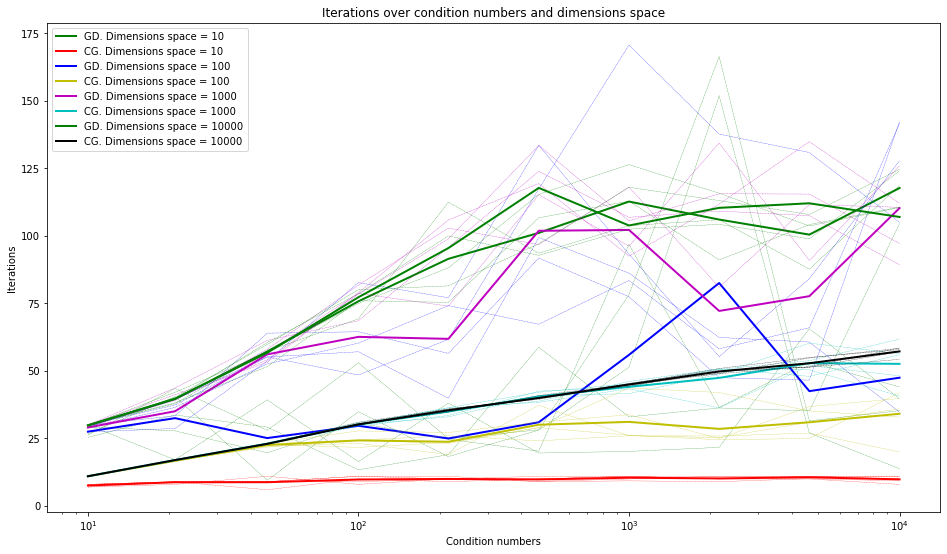

In [50]:
df['avg_time_gd'] = 0
df['avg_time_cg'] = 0
colors = [['g', 'r'], ['b', 'y'], ['m', 'c'], ['g', 'k']]
plt.figure(figsize=(16, 9))
for n, color_ in zip(array_n, colors):
    color = color_[0]
    for i in launches:
        df_ni = df[(df['i'] == i) & (df['n'] == n)]
        plt.plot(df_ni['k'], df_ni['convergence_time_gd'], color=color, linestyle='--', linewidth=.3)
        df.loc[(df['i'] == 0) & (df['n'] == n), 'avg_time_gd'] += (df_ni['convergence_time_gd'].to_numpy()) / len(launches)

    plt.plot(df_n0['k'], df_n0['avg_time_gd'], color=color, linewidth=2, label='GD. Dimensions space = ' + str(n))

    color = color_[1]
    for i in launches:
        df_ni = df[(df['i'] == i) & (df['n'] == n)]
        plt.plot(df_ni['k'], df_ni['convergence_time_cg'], color=color, linestyle='--', linewidth=.3)
        df.loc[(df['i'] == 0) & (df['n'] == n), 'avg_time_cg'] += (df_ni['convergence_time_cg'].to_numpy()) / len(launches)

    df_n0 = df[(df['i'] == 0) & (df['n'] == n)]
    
    plt.plot(df_n0['k'], df_n0['avg_time_cg'], color=color, linewidth=2, label='CG. Dimensions space = ' + str(n))

plt.xlabel('Condition numbers')
plt.ylabel('Iterations')
plt.xscale('log')
# plt.yscale('log')
plt.title('Iterations over condition numbers and dimensions space')
plt.legend()
plt.show()